In [246]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import time
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format', '{:4f}'.format)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import itertools
import pandas as pd
import numpy as np

In [247]:
data = pd.read_csv('diseases.csv')
data.head()

,date,disease,patient_count
0,01-01-2019 00:00,1,9941
1,02-01-2019 00:00,1,9917
2,03-01-2019 00:00,1,9820
3,04-01-2019 00:00,1,9800
4,05-01-2019 00:00,1,9934


In [248]:
diseaseData = data.copy()
diseaseData['date'] = diseaseData['date'].str.replace("/","-")
diseaseData['date'] = pd.to_datetime(data['date'])
diseaseData.sort_values(by=['date','disease'],inplace=True)
diseaseData.head()

,date,disease,patient_count
0,2019-01-01,1,9941
731,2019-01-01,2,2710
1462,2019-01-01,3,7231
2193,2019-01-01,4,3811
31,2019-01-02,1,10081


In [249]:
tmp = diseaseData.groupby(['date','disease'],as_index=False)['patient_count'].mean()
tmp.head()

,date,disease,patient_count
0,2019-01-01,1,9941
1,2019-01-01,2,2710
2,2019-01-01,3,7231
3,2019-01-01,4,3811
4,2019-01-02,1,10081


In [250]:
tmp.set_index('date',inplace=True)

In [251]:
tmp = tmp.groupby('disease',as_index=False).resample('MS').mean()
tmp.head()

disease  patient_count
  date                              
0 2019-01-01 1.000000   10020.032258
  2019-02-01 1.000000   10042.892857
  2019-03-01 1.000000   10042.870968
  2019-04-01 1.000000   10083.433333
  2019-05-01 1.000000   10198.612903

In [252]:
tmp = tmp.reset_index(level=0, drop=True)
tmp.isnull().sum()

disease          0
patient_count    0
dtype: int64

In [253]:
tmp['disease'] = tmp['disease'].astype(int)

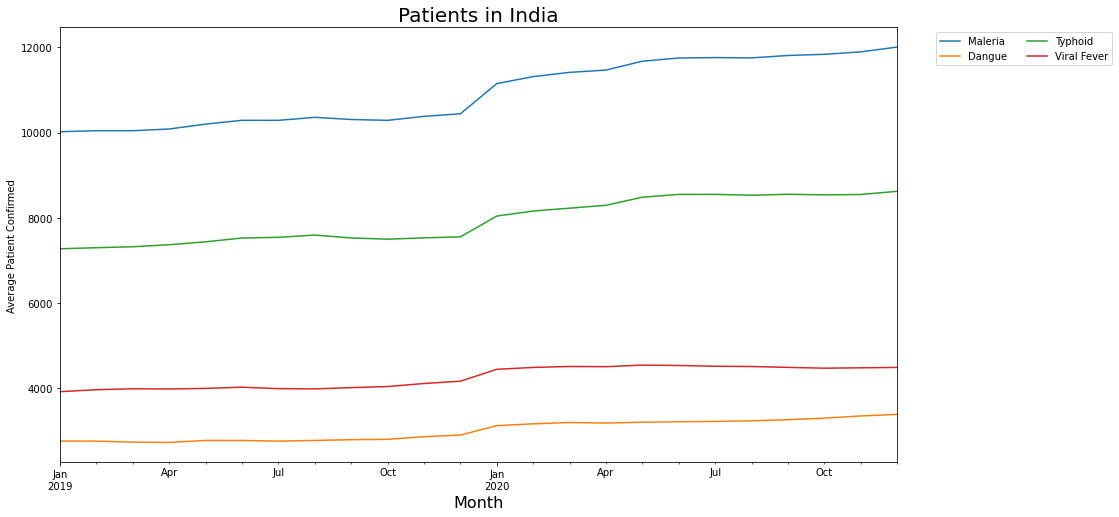

In [254]:
diseaseName = ['Maleria','Dangue','Typhoid','Viral Fever']
diseaseList = [1,2,3,4]
for i,d in zip(diseaseList,diseaseName):
    temp = tmp[tmp.disease == i]
    temp['patient_count'].plot(figsize = (15,8), label=d)


plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Month", fontsize = 16)
plt.ylabel("Average Patient Confirmed")
plt.title('Patients in India', fontsize = 20);

In [255]:
mon_avg = tmp.groupby('date')['patient_count'].mean()
mon_avg = mon_avg.to_frame()
mon_avg = mon_avg.asfreq(freq ='MS')
mon_avg

,patient_count
date,
2019-01-01,5987.967742
2019-02-01,6010.785714
2019-03-01,6016.516129
2019-04-01,6035.400000
2019-05-01,6096.620968
2019-06-01,6147.850000
2019-07-01,6138.991935
2019-08-01,6173.072581
2019-09-01,6155.133333


In [256]:
pd.infer_freq(tmp)

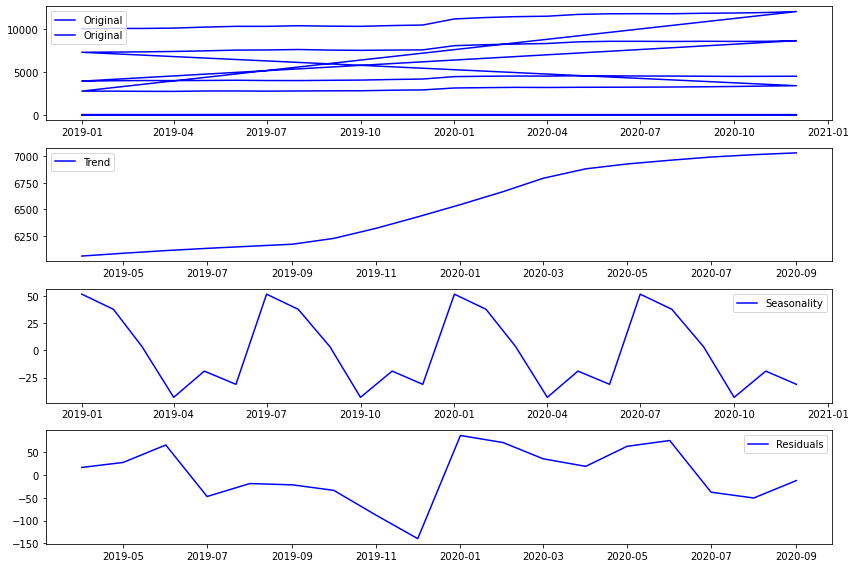

In [257]:
decomposition = sm.tsa.seasonal_decompose(mon_avg, period=6 , model='additive')

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(tmp, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [258]:
def stationarity_check(TS):
    from statsmodels.tsa.stattools import adfuller
    
    roll_mean = TS.rolling(window=2, center=False).mean()
    roll_std = TS.rolling(window=2, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

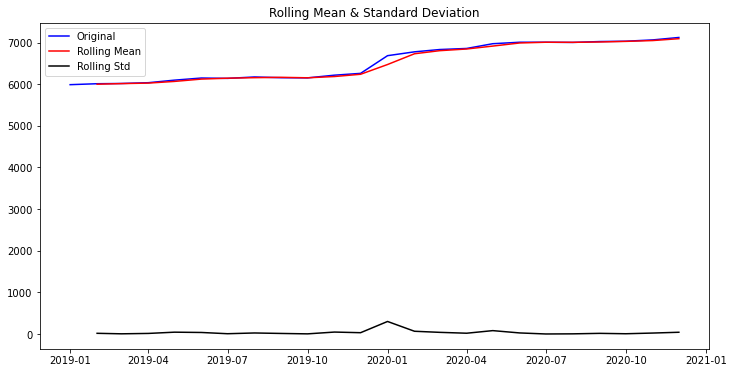

Results of Dickey-Fuller Test: 

Test Statistic                -0.322527
p-value                        0.922253
#Lags Used                     0.000000
Number of Observations Used   23.000000
Critical Value (1%)           -3.752928
Critical Value (5%)           -2.998500
Critical Value (10%)          -2.638967
dtype: float64


In [259]:
ts_log_decompose = mon_avg
ts_log_decompose.dropna(inplace=True)
stationarity_check(ts_log_decompose)

In [260]:
disease_dfs = []
lst = np.array([1,2,3,4])
for x in lst:
    disease_dfs.append(pd.DataFrame(tmp[tmp['disease']==x][['patient_count']].copy()))

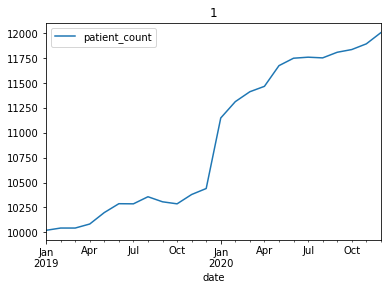

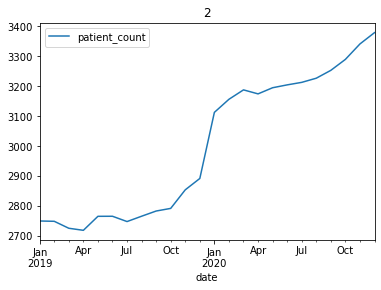

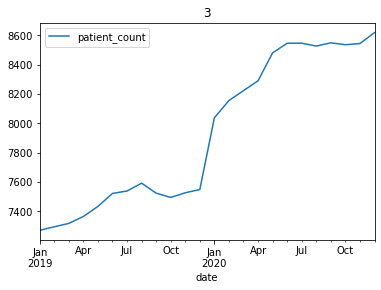

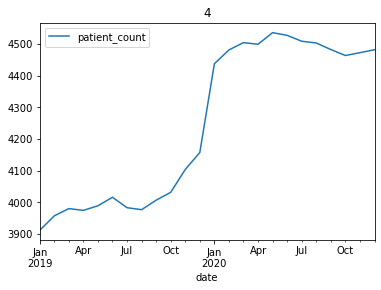

In [261]:
for df,name in zip(disease_dfs, lst):
    df.plot()
    plt.title(name)
    plt.show()

In [262]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [263]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [264]:
pdqs

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [265]:
ans = []

for df, name in zip(disease_dfs, diseaseName):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = True,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

Result for Maleria ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 516.6298746317862
Result for Maleria ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 505.64990853862594
Result for Maleria ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 210.4349836335893
Result for Maleria ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 179.1468051024245
Result for Maleria ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 469.69863757182117
Result for Maleria ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 471.6986370761183
Result for Maleria ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 169.06009806353075
Result for Maleria ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 171.317626346645
Result for Maleria ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 503.70751477479905
Result for Maleria ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 504.72712921924926
Result for Maleria ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 204.11123684053814
Resul

Result for Dangue ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 104.19889102532456
Result for Dangue ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 240.28811421876233
Result for Dangue ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 242.28485520801482
Result for Dangue ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 104.16313449785518
Result for Dangue ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 106.16409141569966
Result for Dangue ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 271.86467233376527
Result for Dangue ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 270.2830170181303
Result for Dangue ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 122.72474758804722
Result for Dangue ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 123.29705358398476
Result for Dangue ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 264.04054170636044
Result for Dangue ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 265.6208472382753
Result for D

Result for Typhoid ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 284.1706797402435
Result for Typhoid ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 128.2216298787066
Result for Typhoid ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 130.40588673122062
Result for Typhoid ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 278.09315091957177
Result for Typhoid ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 280.0873367386705
Result for Typhoid ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 130.27734011240102
Result for Typhoid ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 132.3628640911727
Result for Viral Fever ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 471.20673593179094
Result for Viral Fever ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 460.1809859914858
Result for Viral Fever ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 184.6515749734426
Result for Viral Fever ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 173.1751

In [266]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [267]:
#Return the best set of parameters based on AIC
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]
best_para

,name,pdq,pdqs,AIC
90,Dangue,"(0, 1, 1)","(0, 1, 0, 12)",102.232397
18,Maleria,"(0, 1, 0)","(0, 1, 0, 12)",128.425299
144,Typhoid,"(0, 1, 0)","(0, 1, 0, 12)",124.443631
240,Viral Fever,"(1, 1, 0)","(0, 1, 0, 12)",108.588756


In [268]:
tmp['patient_count'].mean()

6532.07403050347

In [269]:
#fig1, ax1 = plt.subplots()
#ax1.set_title('Basic Plot')
#ax1.boxplot(tmp[:]['patient_count'])

In [270]:
disease_dfs[0]

,patient_count
date,
2019-01-01,10020.032258
2019-02-01,10042.892857
2019-03-01,10042.870968
2019-04-01,10083.433333
2019-05-01,10198.612903
2019-06-01,10287.633333
2019-07-01,10286.387097
2019-08-01,10357.677419
2019-09-01,10306.833333


In [271]:
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], disease_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           freq = 'MS',
                           enforce_stationarity = True,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])

SARIMA Model Result for Dangue
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0082      0.315      0.026      0.979      -0.609       0.625
sigma2      5730.1250   3404.780      1.683      0.092    -943.121    1.24e+04
SARIMA Model Result for Maleria
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       677.4386    299.279      2.264      0.024      90.862    1264.016
SARIMA Model Result for Typhoid
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3991.9538   2096.134      1.904      0.057    -116.393    8100.301
SARIMA Model Result for Viral Fever
                 coef    std err          z      P>|z|      [0.025      0.975]


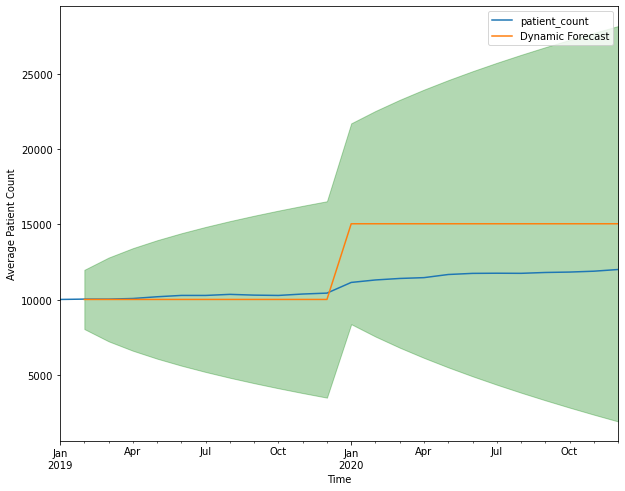

The Mean Squared Error of our forecasts is 2462.89
MAPE : 0.16


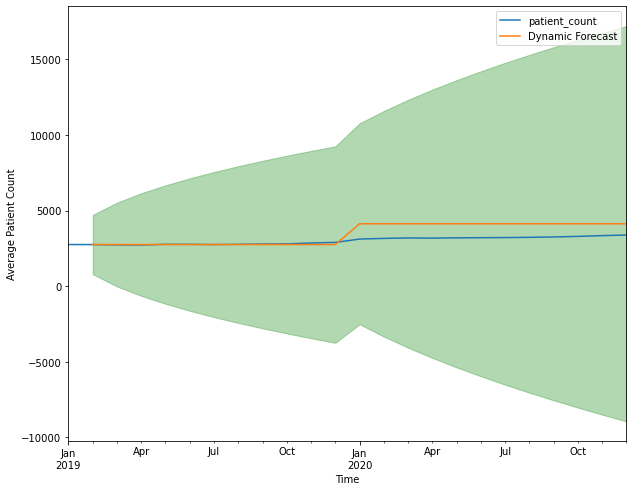

The Mean Squared Error of our forecasts is 652.07
MAPE : 0.15


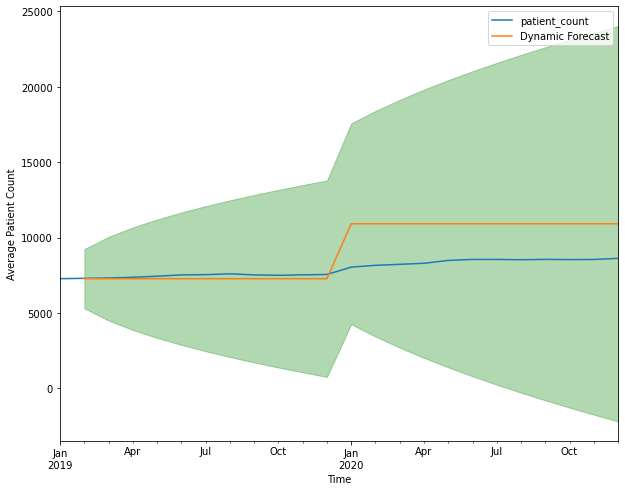

The Mean Squared Error of our forecasts is 1810.34
MAPE : 0.17


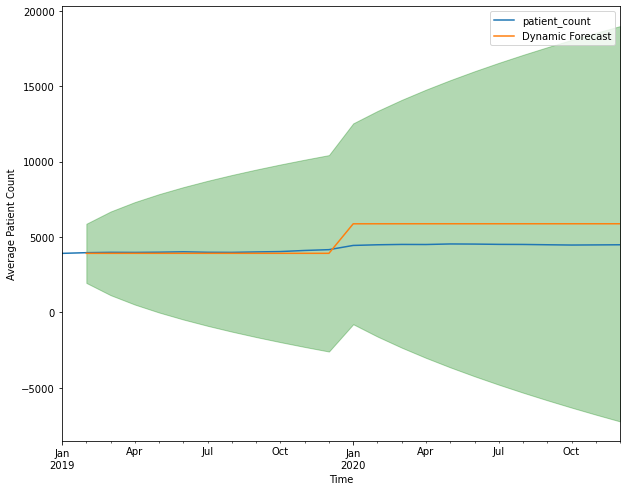

The Mean Squared Error of our forecasts is 1002.16
MAPE : 0.17


In [272]:
summary_table = pd.DataFrame()
Disease = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], disease_dfs):
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 freq = 'MS',
                                 enforce_stationarity = True,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)

    pred_dynamic = output.get_prediction(start='2019-02-01', dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    d_forecasted = pred_dynamic.predicted_mean
    d_truth = df['2019-02-01':]['patient_count']
    
    ax = df.plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)


    ax.set_xlabel('Time')
    ax.set_ylabel('Average Patient Count')

    plt.legend()
    plt.show()

    sqrt_mse = np.sqrt(((d_forecasted - d_truth)**2).mean())
    mape = np.mean(np.abs(d_forecasted - d_truth)/np.abs(d_truth))
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    print('MAPE : {}'.format(round(mape,2)))
    
    Disease.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Disease'] = Disease
summary_table['Sqrt_MSE'] = MSE_Value

In [273]:
forecast_table = pd.DataFrame()
current = []
forecast_1mon = []
forecast_2mon = []
forecast_3mon = []
forecast_4mon = []
forecast_5mon = []
forecast_6mon = []
forecast_7mon = []
forecast_8mon = []
forecast_9mon = []
forecast_10mon = []
forecast_11mon = []
forecast_12mon = []

predicted_data = []

for disease, output, df in zip(Disease, models, disease_dfs):
    pred = []
    pred_conf = [] 
    forecast = []
    for i in range(1,13):
        pred = output.get_forecast(steps = i)      
        forecast.append(pred.predicted_mean.to_numpy()[-1])
    
    current.append(df.loc['2020-12-01']['patient_count'])
    forecast_1mon.append(forecast[0])
    forecast_2mon.append(forecast[1])
    forecast_3mon.append(forecast[2])
    forecast_4mon.append(forecast[3])
    forecast_5mon.append(forecast[4])
    forecast_6mon.append(forecast[5])
    forecast_7mon.append(forecast[6])
    forecast_8mon.append(forecast[7])
    forecast_9mon.append(forecast[8])
    forecast_10mon.append(forecast[9])
    forecast_11mon.append(forecast[10])
    forecast_12mon.append(forecast[11])
    
forecast_table['Disease'] = Disease
forecast_table['Current Value'] = current
forecast_table['1 Month'] = forecast_1mon
forecast_table['2 Months'] = forecast_2mon
forecast_table['3 Months'] = forecast_3mon
forecast_table['4 Months'] = forecast_4mon
forecast_table['5 Months'] = forecast_5mon
forecast_table['6 Months'] = forecast_6mon
forecast_table['7 Months'] = forecast_7mon
forecast_table['8 Months'] = forecast_8mon
forecast_table['9 Months'] = forecast_9mon
forecast_table['10 Months'] = forecast_10mon
forecast_table['11 Months'] = forecast_11mon
forecast_table['12 Months'] = forecast_12mon

In [274]:
forecast_table

,Disease,Current Value,1 Month,2 Months,3 Months,4 Months,5 Months,6 Months,7 Months,8 Months,9 Months,10 Months,11 Months,12 Months
0,Dangue,12007.967742,12717.854152,12882.153373,12981.789636,13035.982109,13244.176733,13318.815442,13329.144474,13322.176733,13378.648776,13405.983184,13463.282109,13575.983184
1,Maleria,3378.516129,3599.096774,3642.718576,3674.129032,3660.780645,3681.258065,3690.780645,3699.193548,3713.064516,3739.313978,3775.838710,3827.380645,3865.096774
2,Typhoid,8618.967742,9108.483871,9226.067853,9293.451613,9361.082796,9551.483871,9617.116129,9617.677419,9597.677419,9620.149462,9607.032258,9615.082796,9689.483871
3,Viral Fever,4481.580645,4736.474858,4765.973833,4781.188925,4771.541290,4805.687182,4795.765102,4776.360023,4770.366840,4749.512452,4730.460013,4739.392783,4748.562310


In [275]:
models

In [276]:
for m,z in zip(models,Disease):
    m.save(str(z)+'.pkl')

In [50]:
import pickle
from datetime import date

import mysql.connector

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="health",
    port=3306
)

mycursor = mydb.cursor()

emptyQuery = "TRUNCATE TABLE prediction;"
mycursor.execute(emptyQuery)


diseases = ['Maleria','Dangue','Typhoid','Viral Fever']

data = {}

for d in diseases:
    fileName = d + '.pkl'
    with open(fileName, 'rb') as file:
        model = pickle.load(file)
    
    data[d] = {}
    for i in range(1,13):
        pred = model.get_forecast(steps = i)
        forecast = pred.predicted_mean.to_numpy()[-1]
        data[d][i] = int(forecast)
        
for month in range(1,13):
    query = "INSERT INTO prediction (location, malaria, dangue, typhoid, viral_fever) VALUES (%s, %s, %s, %s, %s)"
    val = (0, data[diseases[0]][month], data[diseases[1]][month], data[diseases[2]][month], data[diseases[3]][month])
    mycursor.execute(query, val)

mydb.commit()

In [51]:
pip install mysql-connector-python-rf
pip install pickle
or
pip install pickle5

SyntaxError: invalid syntax (<ipython-input-51-e55d8db039d8>, line 1)

In [55]:
from platform import python_version

print(python_version())

3.8.3
